In [1]:
import argparse
import os
import sys
import time

import cv2
import numpy as np
import PIL
import tensorflow as tf
import yaml

tf.enable_eager_execution()
import matplotlib.pyplot as plt
from tensorflow import keras
from utils import load_lrt_human, make_log_folder

"""
CFG AUTO-PARSING FIELD PAIR LIST
1. IF THE FIELD NAME IS SAME FOR BOTH INVERSION AND GAN TRAINING CONFIG, JUST ENTER THE LIST WITH THE FIELD NAME,
E.G, [NAME]

2. IF THE FIELD NAME YOU WISH TO COPY FROM IS DIFFERENT, ENTER THE LIST WITH INVERSION CONFIG FIRST THEN THE GAN TRAINING CONFIG
E.G, [NAME_IN_INV_CONFIG, NAME_IN_GAN_CONFIG]
"""
cfg_keypair_list = [["THERMAL_PATH"], ["RGB_PATH"], ["GENERATOR"]]
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # TODO

In [2]:
# GPU USAGES
physical_devices = tf.config.experimental.list_physical_devices("GPU")
if len(physical_devices) > 0:
    # SET GPU MEMORY LIMIT
    # tf.config.experimental.set_virtual_device_configuration(physical_devices[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=16000)])
    # SET GPU GROWTH LIMIT
    # tf.config.experimental.set_memory_growth(physical_devices[0], True)
    for gpu in physical_devices:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("No GPU hardware devices available")

In [3]:
thermal_images, rgb_images = load_lrt_human(
    "./thermal_demo.npy", "./rgb_demo.npy", use_shuffle=False
)
thermal_images.shape, rgb_images.shape

Loading: ./rgb_demo.npy
Loading: ./thermal_demo.npy


((5009, 5, 8, 1), (5009, 40, 64, 3))

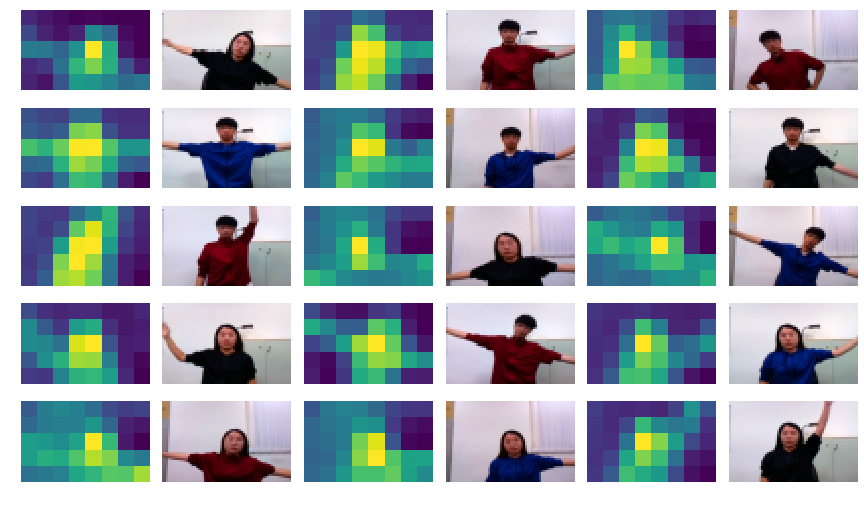

In [4]:
import random as rd

figure, axe = plt.subplots(5, 6, figsize=(15, 9))

for i in range(15):
    idx = rd.randint(0, 5000)
    axe[i % 5][(i // 5) * 2].imshow(thermal_images[idx, :, :, 0])
    axe[i % 5][(i // 5) * 2].axis("off")
    axe[i % 5][(i // 5) * 2 + 1].imshow(rgb_images[idx] / 2 + 0.5)
    axe[i % 5][(i // 5) * 2 + 1].axis("off")

plt.subplots_adjust(wspace=0.1, hspace=0)
plt.show()

In [5]:
generator = keras.models.load_model("./G_40.h5")
encoder = keras.models.load_model("./E_80.h5")

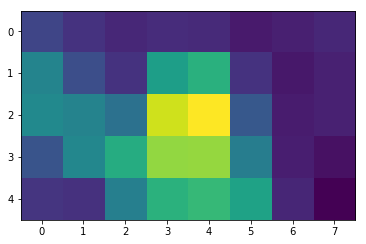

In [6]:
# ##
import glob
import re
import time

import cv2
import matplotlib
import PIL
from scipy import stats
from scipy.ndimage.filters import gaussian_filter


def process_raw_thermal(thermal_path: str, noise: int = 3000) -> tuple:
    thermal = np.load(thermal_path)
    thermal = gaussian_filter(thermal, sigma=10)
    thermal = thermal + np.random.normal(scale=noise, size=thermal.shape)
    thermal = cv2.resize(thermal, dsize=(8, 5), interpolation=cv2.INTER_AREA)
    thermal = cv2.normalize(thermal, None, -1, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    thermal = np.expand_dims(thermal, axis=2)
    return thermal


test_thermal = process_raw_thermal("./receive_raw_thermal.npy")

plt.imshow(test_thermal[:, :, 0])

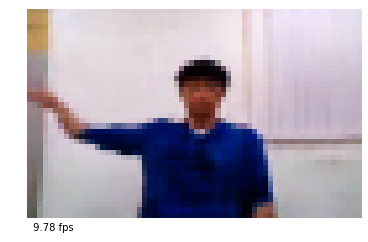

In [19]:
def demo_loop():
    global r, encoder, generator
    if "inline" in matplotlib.get_backend():
        from IPython import display

        display.clear_output(wait=True)
    t_s = time.time()
    env_id = int(glob.glob(os.path.join(".", "env_id=*"))[0][-1])
    ref_rgbs = rgb_images[[1200, 3900]]
    source_codes = encoder(ref_rgbs, training=False)
    rgb = generator(
        [
            tf.repeat(
                [process_raw_thermal("./receive_raw_thermal.npy")],
                len(ref_rgbs),
                axis=0,
            ),
            source_codes,
        ],
        training=False,
    )
    plt.axis('off')
    plt.imshow(rgb[env_id] / 2 + 0.5)
    plt.text(0,42,f"{1/(time.time() - t_s):5.2f} fps")
    plt.show()

demo_loop()

In [30]:
while True:
    try:
        demo_loop()
    except KeyboardInterrupt as e:
        print('User stop.', e)
        break

User stop. 
